# Introduction to Convolutional Neural Networks

In this notebook we will see how to define and use a Convolutional Neural Network (CNN) for clasifing images.

Contrary to the MLPs we have used up to know, where each unit connects to all the units of the previous layer, a unit in a convoutional layer only "sees" a small region of the layer before, and applies a filter - a local operation - on this small region. The key idea is to apply this same filter to the whole image in a grid fashion, which results into a map of activations for this filter. Using many filters, results into a set of activation maps that when stacked together will form the output of the convolutional layer (each activation map corresponding to a "channel").

Typically, convolutions are followed by pooling layers that reduce the dimensionality of our intermedate result, and give us every time a little bit more of viewpoint invariance (at the cost of losing precise information about the location of things).

When dealing with images, our inputs, and all intermediate tensors we produce through convolution layers will be 3-dimensional tensors. And if we vectorise our operations and pass a whole batch of images in a single go, we will be dealing with 4-dimensional tensors. The ordering of the dimensions in pytorch is $(BatchSize \times nChannels \times Height \times Width)$.

After a series of convolutions and pooling operations, we typically want to flaten the images. The flattening operation collapses an array into a 1-dimensional vector. For example, if we have a tensor of $20 \times 5 \times 5$ $(C \times H \times W)$, its flattened version is a 1d vector of $500$ values. Now we can feed these $500$ values into a MLP for classifiying the image.

In [26]:
import torch #should be installed by default in any colab notebook
import numpy as np
import matplotlib.pyplot as plt
from IPython import display
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import matplotlib.pyplot as plt

# function to count number of parameters
def get_n_params(model):
    np=0
    for p in list(model.parameters()):
        np += p.numel()
    return np

In [27]:
# If this cell fails you need to change the runtime of your colab notebook to GPU
# Go to Runtime -> Change Runtime Type and select GPU
assert torch.cuda.is_available(), "GPU is not enabled"

# use gpu if available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

print("Using device:", device)

Using device: cuda:0


# Data

Before training we need data! For this notebook we will use the FashionMNIST dataset. Which is available in [torchvision](https://pytorch.org/vision/stable/index.html)


In [28]:
train_set = datasets.FashionMNIST("data", train=True, download=True, transform=transforms.Compose([transforms.ToTensor(), transforms.RandomHorizontalFlip()]))
val_set = datasets.FashionMNIST("data", train=False, download=True, transform=transforms.Compose([transforms.ToTensor()]))

train_loader = torch.utils.data.DataLoader(train_set, batch_size=256, shuffle=True, num_workers=2)
val_loader = torch.utils.data.DataLoader(val_set, batch_size=512, shuffle=False, num_workers=2)

The images of FashionMNIST are of size $(28 \times 28)$ pixels, and have a single channel - the greyscale one. So they are given as a 2D tensor. You can easily check this:

In [29]:
img = train_set.data[0]
img.shape

torch.Size([28, 28])

## Filters and Convolutional layers

To define a CNN model, similarly to the MLP case, we need to define all the operations and then combine them into the forward pass. Apart from `nn.Linear()` layers, we will now use `nn.Conv2d()` layers, which correspond to 2D convolutions.

To perform a convolution, we need to define the size of our filters, and how many filters to use.

The size of the filter is given by its width and height (which will be equal), and the number of channels which has to be the same as the number of channels of the input it will be applied to. So, if `in_channels` is the number of channels of the input, and `kernel_size` is the width and height of our filter, then our filter will be a tensor of shape $(in\_channels \times kernel\_size \times kernel\_size)$.

The other piece of information needed is how many filters to use. Remember that each filter gives rise to one activation map, which in turn corresponds to one channel in the output. So the number of filters to use is the same as the number of output channels (`out_channels`) we want to have.

Internally, the set of weights that represent all the filters of a convolutional layer is stored as a single 4D tensor of shape (Number of filters, Number of channels, Height, Width), which would be equivalently $(out\_channels \times in\_channels \times kernel\_size \times kernel\_size)$

This is the minimum information needed to define a convolution layer. Unless otherwise specified, this would apply a default padding of zero and stride of 1. Have a look at the documentation for more details on the `nn.Conv2d()` layer.

https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html?highlight=conv#torch.nn.Conv2d

Finally, remember the formula to calculate the size of the output $o$ given the input size $n$ the filter size $f$ the padding $p$ and the stride $s$:

$o = {\frac {(n + 2p - f)} s} + 1$

<br>
<span style="color:blue">

**Exercise 1**: Given the following convolutional layer:

`nn.Convd2(in_channels=20, out_channels=128, kernel_size=3)`

What is the shape of the weights and biases of the convolutional layer?

</span>

---

*Your Answer Here*

---

## Our Convolutional Model

Let's define now our first CNN model. 

In [30]:
class CNN(nn.Module):
    def __init__(self, n_feature, output_size):
        super(CNN, self).__init__()
        self.n_feature = n_feature
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=n_feature, kernel_size = 5)
        self.conv2 = nn.Conv2d(n_feature, n_feature, kernel_size=5)
        self.fc1 = nn.Linear(n_feature, 50)
        self.fc2 = nn.Linear(50, 10)
        self.maxpool = nn.MaxPool2d(kernel_size=2)
        
    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.maxpool(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = self.maxpool(x)
        x = x.view(-1, self.n_feature)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        return x

<font color="blue">**Exercise 2**: The model defined above has a shape mismatch problem. Calculate the correct input dimension for `fc1` and change its definition in the `__init__()` method and the call to `x.view()` in the forward pass. </font>

In [ ]:
class CNN(nn.Module):
    def __init__(self, n_feature, output_size):
        super(CNN, self).__init__()
        self.n_feature = n_feature
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=n_feature, kernel_size=5)
        self.conv2 = nn.Conv2d(in_channels=n_feature, out_channels=n_feature**2, kernel_size=5)
        self.fc1 = nn.Linear(in_features=(n_feature**2)*4*4, out_features=50)
        self.fc2 = nn.Linear(in_features=50, out_features=10)
        self.maxpool = nn.MaxPool2d(kernel_size=2)
        
    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.maxpool(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = self.maxpool(x)
        x = x.view(-1, (self.n_feature**2)*4*4)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        return x


## Hyperparameters

To use our CNN we need to create our model and define our hyperparameters. We will use an output size of 10, as there are 10 classes in FashionMNIST, and we will train with cross entropy loss and stochastic gradient descent.

In [32]:
torch.backends.cudnn.benchmark = True
learning_rate = 1e-2
lambda_l2 = 1e-5
momentum = 0.5
torch.manual_seed(0) # seed for reproductibility

output_size = 10  # there are 10 classes

model = CNN(6, output_size)

print(f"Number of parameters {get_n_params(model)}:")

# move model to gpu if available
model.to(device)

# nn package also has different loss functions.
# we use cross entropy loss for our classification task
criterion = torch.nn.CrossEntropyLoss() # https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html#torch.nn.CrossEntropyLoss

# we use the optim package to apply
# stochastic gradient descent for our parameter updates
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=momentum, weight_decay=lambda_l2) # built-in L2

Number of parameters 34952:


<br>
<span style="color:blue">

**Exercise 3**: What does the line `torch.backends.cudnn.benchmark = True` do? How will it affect our runtime if the size of the input images vary a lot?</font>

> Hint: Have a look at https://pytorch.org/docs/stable/backends.html

</span>

---

*Your Answer Here*

---

## Training and Validation

We should also define our training and validation loops. These are similar to previous notebooks.

In [33]:
@torch.no_grad()  # prevent this function from computing gradients 
def validate(criterion, model, loader):

    val_loss = 0
    correct = 0

    model.eval()

    for data, target in loader:

        data, target = data.to(device), target.to(device)

        output = model(data)
        loss = criterion(output, target)
        val_loss += loss.item()                                                              
        pred = output.data.max(1, keepdim=True)[1] # get the index of the max log-probability                                                                 
        correct += pred.eq(target.view_as(pred)).sum().item()

    val_loss /= len(loader.dataset)
    accuracy = 100. * correct / len(loader.dataset)
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        val_loss, correct, len(loader.dataset), accuracy))


    return val_loss


def train(epoch, criterion, model, optimizer, loader):
    
    total_loss = 0.0

    model.train()

    for batch_idx, (data, target) in enumerate(loader):
        
        optimizer.zero_grad()

        data, target = data.to(device), target.to(device)
        
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % 100 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(loader.dataset),
                100. * batch_idx / len(loader), loss.item()))


        total_loss += loss.item()  #.item() is very important here? Why?

    return total_loss / len(loader.dataset)

### Run Training

Train Epoch: 0 [0/60000 (0%)]	Loss: 2.301897
Train Epoch: 0 [25600/60000 (43%)]	Loss: 2.275393
Train Epoch: 0 [51200/60000 (85%)]	Loss: 2.201091

Test set: Average loss: 0.0041, Accuracy: 3793/10000 (38%)



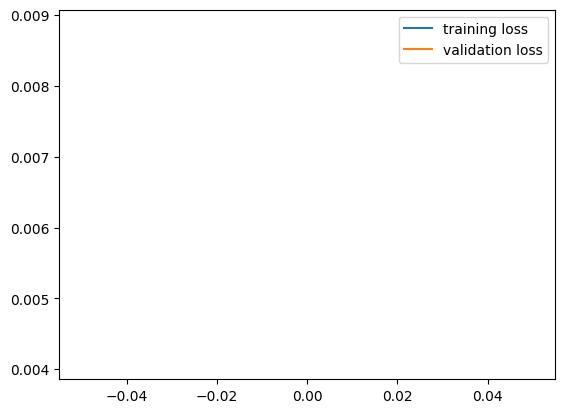

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.034274
Train Epoch: 1 [25600/60000 (43%)]	Loss: 1.153717
Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.847348

Test set: Average loss: 0.0018, Accuracy: 6525/10000 (65%)



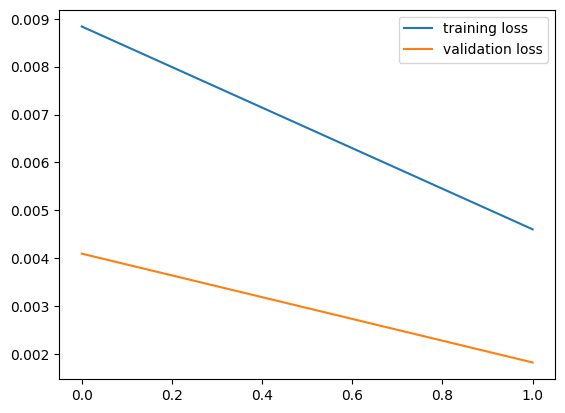

Train Epoch: 2 [0/60000 (0%)]	Loss: 0.910903
Train Epoch: 2 [25600/60000 (43%)]	Loss: 0.709632
Train Epoch: 2 [51200/60000 (85%)]	Loss: 0.738120

Test set: Average loss: 0.0015, Accuracy: 7256/10000 (73%)



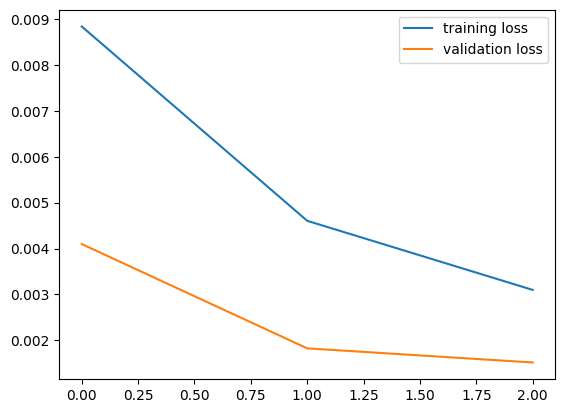

Train Epoch: 3 [0/60000 (0%)]	Loss: 0.619252
Train Epoch: 3 [25600/60000 (43%)]	Loss: 0.612674
Train Epoch: 3 [51200/60000 (85%)]	Loss: 0.761343

Test set: Average loss: 0.0014, Accuracy: 7377/10000 (74%)



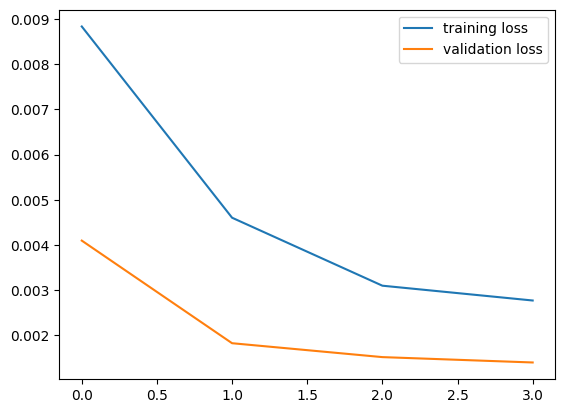

Train Epoch: 4 [0/60000 (0%)]	Loss: 0.621438
Train Epoch: 4 [25600/60000 (43%)]	Loss: 0.672766
Train Epoch: 4 [51200/60000 (85%)]	Loss: 0.717331

Test set: Average loss: 0.0013, Accuracy: 7515/10000 (75%)



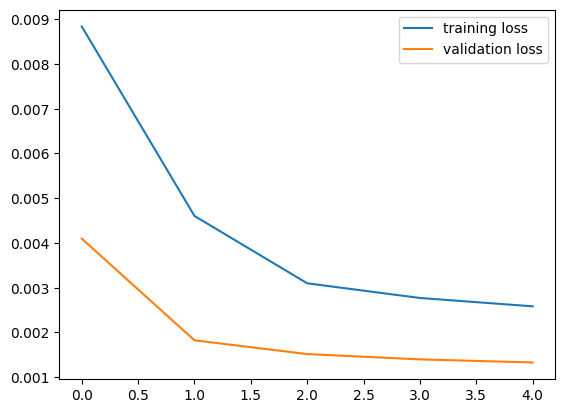

Train Epoch: 5 [0/60000 (0%)]	Loss: 0.577052
Train Epoch: 5 [25600/60000 (43%)]	Loss: 0.657595
Train Epoch: 5 [51200/60000 (85%)]	Loss: 0.652012

Test set: Average loss: 0.0012, Accuracy: 7693/10000 (77%)



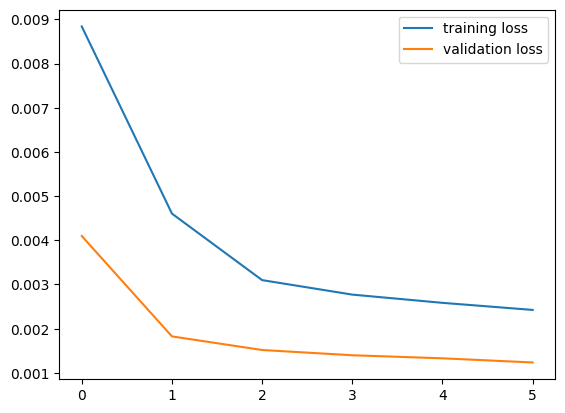

Train Epoch: 6 [0/60000 (0%)]	Loss: 0.606094
Train Epoch: 6 [25600/60000 (43%)]	Loss: 0.560213
Train Epoch: 6 [51200/60000 (85%)]	Loss: 0.626630

Test set: Average loss: 0.0012, Accuracy: 7827/10000 (78%)



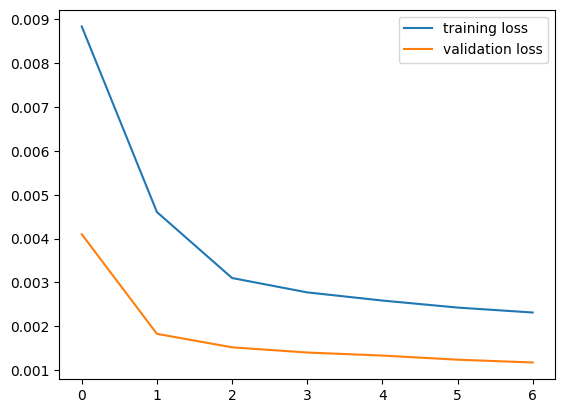

Train Epoch: 7 [0/60000 (0%)]	Loss: 0.531998
Train Epoch: 7 [25600/60000 (43%)]	Loss: 0.531798
Train Epoch: 7 [51200/60000 (85%)]	Loss: 0.540614

Test set: Average loss: 0.0012, Accuracy: 7792/10000 (78%)



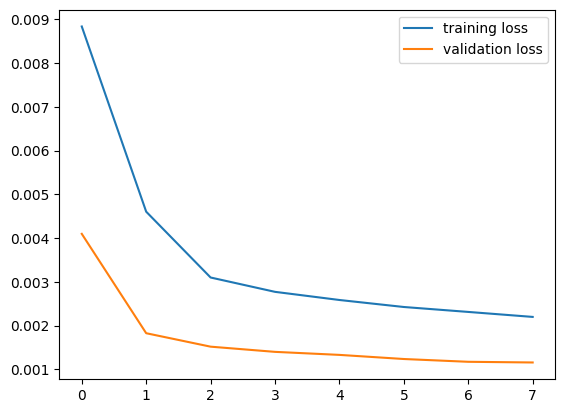

Train Epoch: 8 [0/60000 (0%)]	Loss: 0.635155
Train Epoch: 8 [25600/60000 (43%)]	Loss: 0.602411
Train Epoch: 8 [51200/60000 (85%)]	Loss: 0.539258

Test set: Average loss: 0.0011, Accuracy: 8019/10000 (80%)



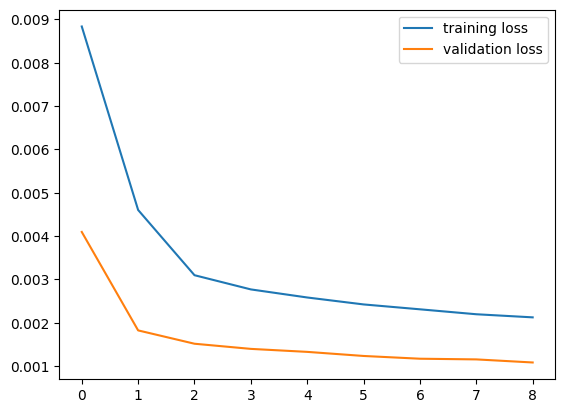

Train Epoch: 9 [0/60000 (0%)]	Loss: 0.430996
Train Epoch: 9 [25600/60000 (43%)]	Loss: 0.623459
Train Epoch: 9 [51200/60000 (85%)]	Loss: 0.558799

Test set: Average loss: 0.0011, Accuracy: 7849/10000 (78%)



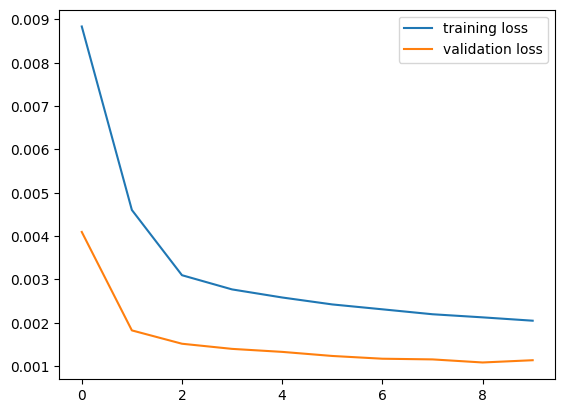

In [34]:
losses = {"train": [], "val": []}
for epoch in range(10):

    train_loss = train(epoch, criterion, model, optimizer, train_loader)
    val_loss = validate(criterion, model, val_loader)
    losses["train"].append(train_loss)
    losses["val"].append(val_loss)
    
    plt.plot(losses["train"], label="training loss")
    plt.plot(losses["val"], label="validation loss")

    plt.legend()
    plt.pause(0.000001)
    plt.show()

It may also be useful to visualize some qualitative examples of classification 

Correctly predicted: 80.859375%


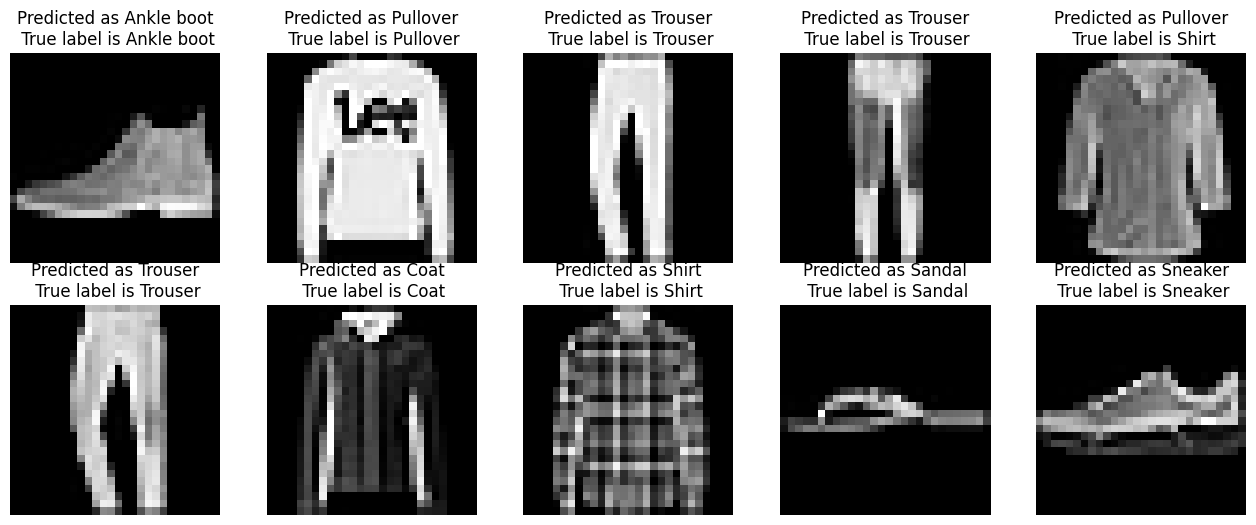

In [35]:
with torch.no_grad():

    data, target = next(iter(val_loader))
    data, target = data.to(device), target.to(device)

    output = model(data)
    predictions = np.argmax(output.cpu().numpy(), axis=1).tolist()
    true = target.cpu().numpy().tolist()
      
    plt.figure(figsize=(16, 6))
    
    print("Correctly predicted: {}%".format(100*sum(p == t for p, t in zip(predictions, true))/len(predictions)) )

    for i in range(10):
        plt.subplot(2, 5, i + 1)
        image = data[i,...].cpu().numpy().reshape((28,28))
        plt.imshow(image, cmap="gray")
        plt.axis('off')
        plt.title('Predicted as {}\n True label is {}'.format(val_set.classes[predictions[i]], val_set.classes[true[i]], ))

<br>
<span style="color:blue">
    
**Exercise 4**: Now repeat the same process, but flip the images horizontally before you run them through the model. Is your accuracy affected? Why?

>Hint: Check the `numpy.flip()` function

</span>

Correctly predicted: 80.2734375%


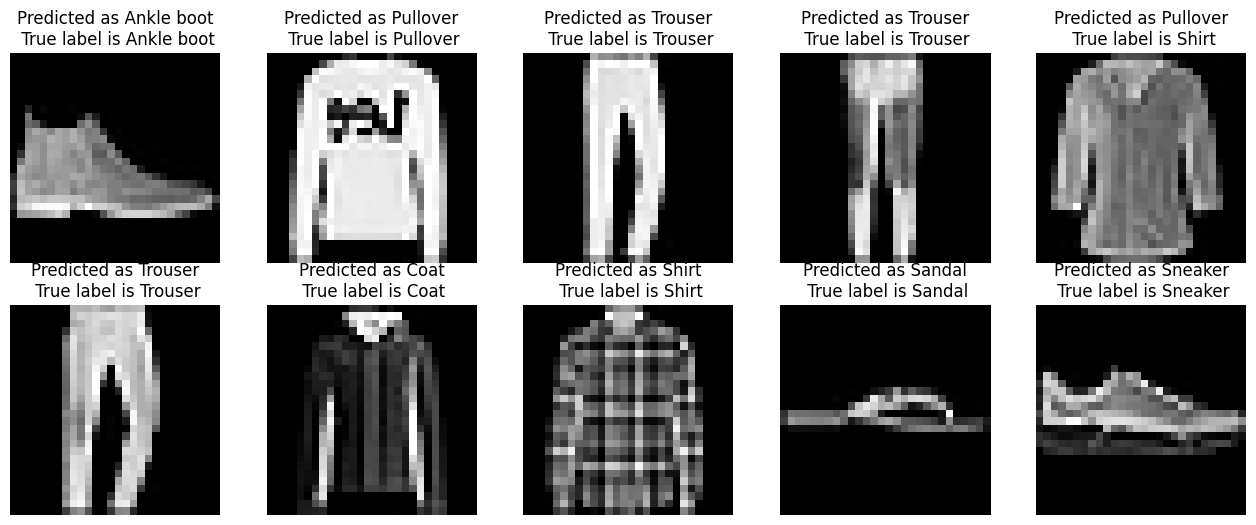

In [50]:
# Your Code Here
with torch.no_grad():

    data, target = next(iter(val_loader))
    data = torch.from_numpy(np.flip(data.cpu().numpy(), axis=3).copy()).to(device)
    data, target = data.to(device), target.to(device)

    output = model(data)
    predictions = np.argmax(output.cpu().numpy(), axis=1).tolist()
    true = target.cpu().numpy().tolist()
      
    plt.figure(figsize=(16, 6))
    
    print("Correctly predicted: {}%".format(100*sum(p == t for p, t in zip(predictions, true))/len(predictions)) )

    for i in range(10):
        plt.subplot(2, 5, i + 1)
        image = data[i,...].cpu().numpy().reshape((28,28))
        plt.imshow(image, cmap="gray")
        plt.axis('off')
        plt.title('Predicted as {}\n True label is {}'.format(val_set.classes[predictions[i]], val_set.classes[true[i]], ))

## Visualising Filters

One thing that would be interesting to visualise is the weights of the filters. To do so, we just need to access the weights of the convolutional layer of interest, and turn them into images. Here's an example for the first convolutional layer.

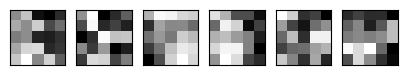

In [37]:
weight = model.conv1.weight.data.cpu().numpy()

# Display the filters
fig, ax = plt.subplots(1, weight.shape[0], figsize=(5, 5))

for i in range(weight.shape[0]):
    ax[i].imshow(weight[i, 0], cmap='gray') # show the first (and only) channel weights
    ax[i].axes.get_xaxis().set_visible(False)        
    ax[i].axes.get_yaxis().set_visible(False)

## Visualising Activation Maps

Another thing would be to visualise the activations of a convolutional layer for a specific image when it goes through the model. To do so, we need to somehow capture the output of the convolutional layer during the forward pass. This can be done with the function `nn.Conv2d.register_forward_hook()`. This function accepts as argument a callback function that will be called by the model when the forward pass takes place.

See some more information about this function below:

In [53]:
nn.Conv2d.register_forward_hook??

Signature:
nn.Conv2d.register_forward_hook(
    self,
    hook: Union[Callable[[~T, Tuple[Any, ...], Any], Optional[Any]], Callable[[~T, Tuple[Any, ...], Dict[str, Any], Any], Optional[Any]]],
    *,
    prepend: bool = False,
    with_kwargs: bool = False,
    always_call: bool = False,
) -> torch.utils.hooks.RemovableHandle
Source:   
    def register_forward_hook(
        self,
        hook: Union[
            Callable[[T, Tuple[Any, ...], Any], Optional[Any]],
            Callable[[T, Tuple[Any, ...], Dict[str, Any], Any], Optional[Any]],
        ],
        *,
        prepend: bool = False,
        with_kwargs: bool = False,
        always_call: bool = False,
    ) -> RemovableHandle:
        r"""Register a forward hook on the module.

        The hook will be called every time after :func:`forward` has computed an output.

        If ``with_kwargs`` is ``False`` or not specified, the input contains only
        the positional arguments given to the module. Keyword arguments won't 

To try this out, we will defineby hand a toy model that does edge detection, as well as a couple of images to apply it on

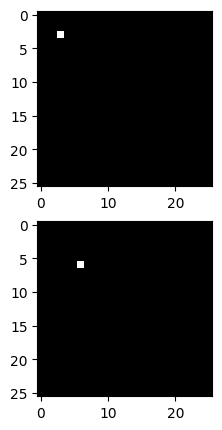

In [54]:
simpleEdgeDetector = nn.Conv2d(in_channels=1, out_channels=2, kernel_size=3)

# Define a vertical edge detector filter
simpleEdgeDetector.weight.data[0, 0] = torch.tensor([  [1., 0., -1.],
                                                   [1., 0., -1.],
                                                   [1., 0., -1.]])

# Define an horizontal edge detector filter
simpleEdgeDetector.weight.data[1, 0] = torch.tensor([  [1., 1., 1.],
                                                   [0., 0., 0.],
                                                   [-1., -1., -1.]])

simpleEdgeDetector.bias.data = torch.zeros(2)

simpleEdgeDetector = simpleEdgeDetector.to(device)


fakeImageBatch = torch.zeros(2, 1, 26, 26) # create a batch of two black images of (10, 10)
fakeImageBatch[0,0,3,3] = 1 # Paint white pixel (3, 3)
fakeImageBatch[1,0,6,6] = 1 # Paint white pixel (6, 6)

# Show the images
fig, ax = plt.subplots(2, 1, figsize=(5, 5))
ax[0].imshow(fakeImageBatch[0,0], cmap='gray')
ax[1].imshow(fakeImageBatch[1,0], cmap='gray')

Let's also define some helper functions to plot a grid of activation maps given the output of a convolution layer.

In [55]:
def showImage(img, ax):
    # convert the tensor to numpy
    out = img.numpy()
    # Bring to the 0-255 range
    out = out - out.min()
    out = out / out.max()
    out = out * 255
    out = out.astype('uint8')
    # Plot image
    ax.axes.get_xaxis().set_visible(False)        
    ax.axes.get_yaxis().set_visible(False)
    ax.imshow(out, cmap='gray')

def showConvMap(conv_map):
    # Create a grid of images
    h = conv_map.shape[0] # = number of images in the batch
    w = conv_map.shape[1] # = number of activation maps per image
    fig, ax = plt.subplots(h, w, figsize=(10, 10))

    # Plot activation maps
    for i in range(conv_map.shape[0]):
        for j in range(conv_map.shape[1]):
            showImage(conv_map[i][j], ax[i, j])
    
    fig.tight_layout()

Now we can define our hook function, which just calls `showConvMap()` to plot the output activation maps for all the images of our batch and all the filters of this layer.

Output shape: torch.Size([2, 2, 24, 24])


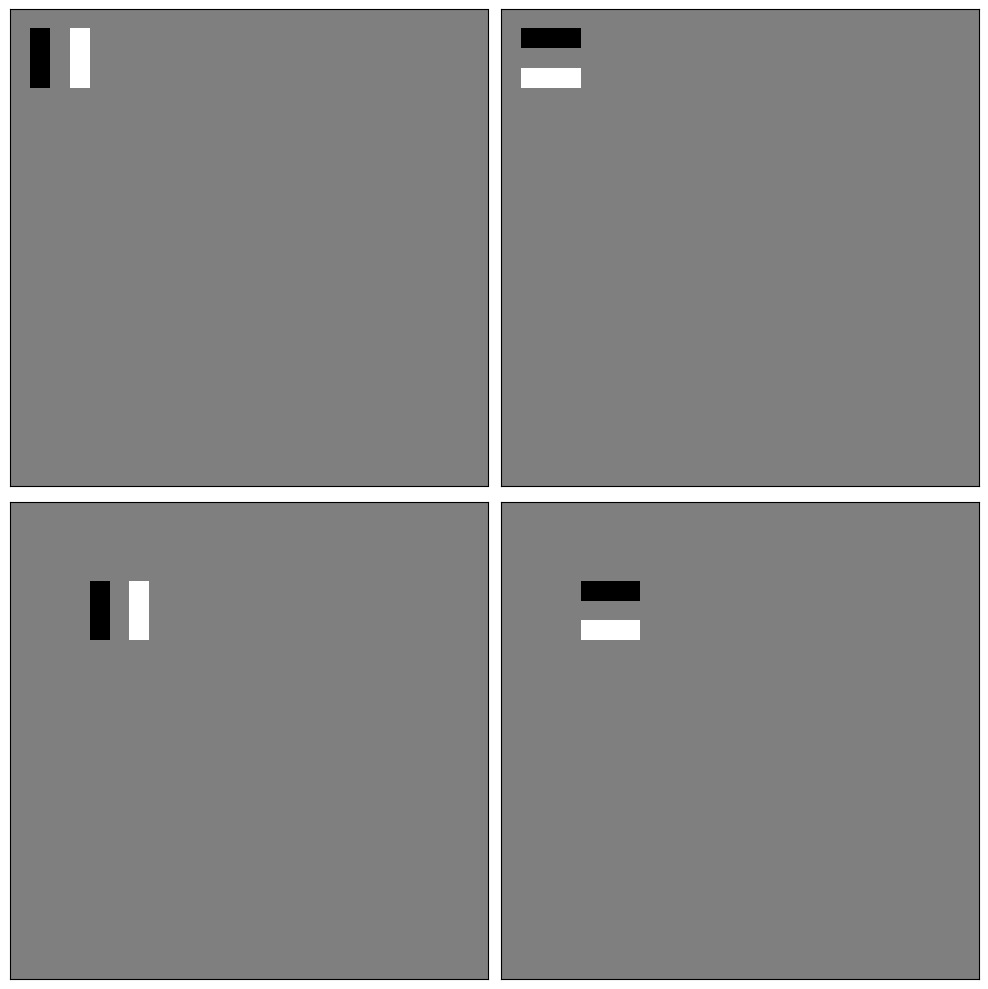

In [56]:
def hook_ShowOutput(module, input, output):
    print("Output shape:", output.shape)
    showConvMap(output.cpu())

fakeImageBatch = fakeImageBatch.to(device)

with torch.no_grad():
    handle = simpleEdgeDetector.register_forward_hook(hook_ShowOutput)
    embed = simpleEdgeDetector(fakeImageBatch)
    handle.remove()

<br>
<span style="color:blue">
    
**Exercise 5**: Visualize the feature (activation) maps of the first and last convolutional layers of our CNN model for 10 images of your validation set. Use the code provided before as the basis for your visualisation. What conclusions can you draw?
    
</span>

Output shape: torch.Size([10, 6, 24, 24])
Output shape: torch.Size([10, 36, 8, 8])


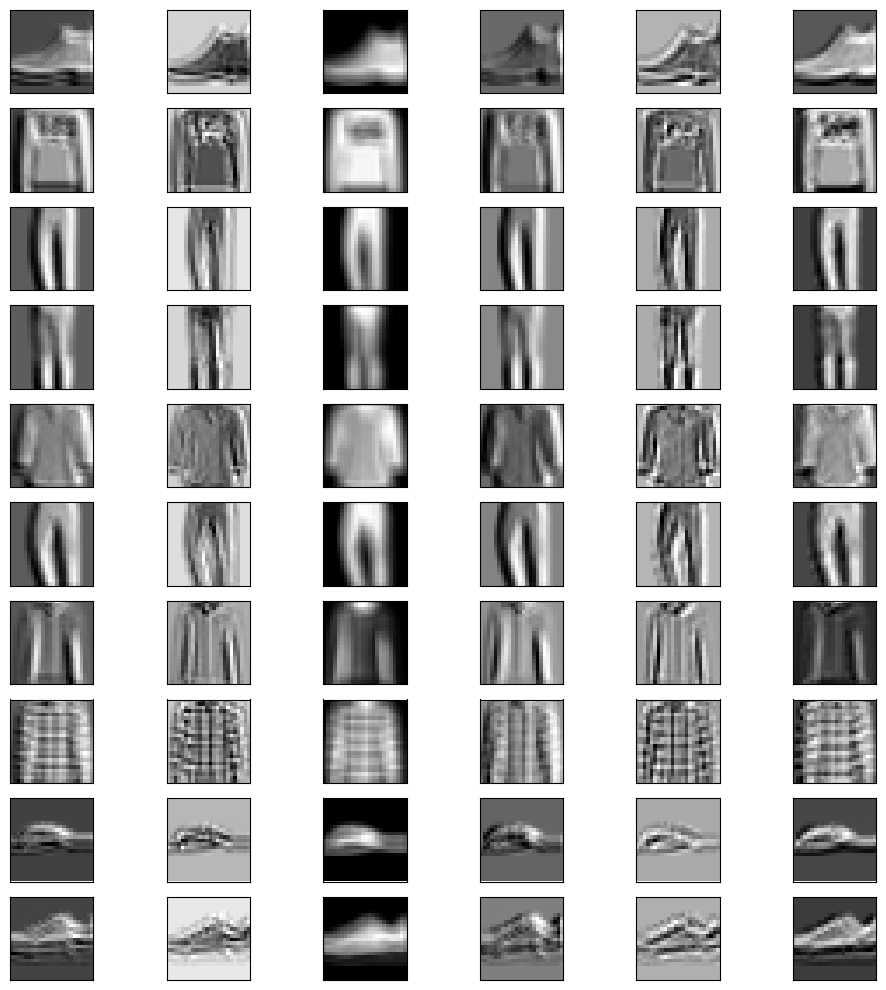

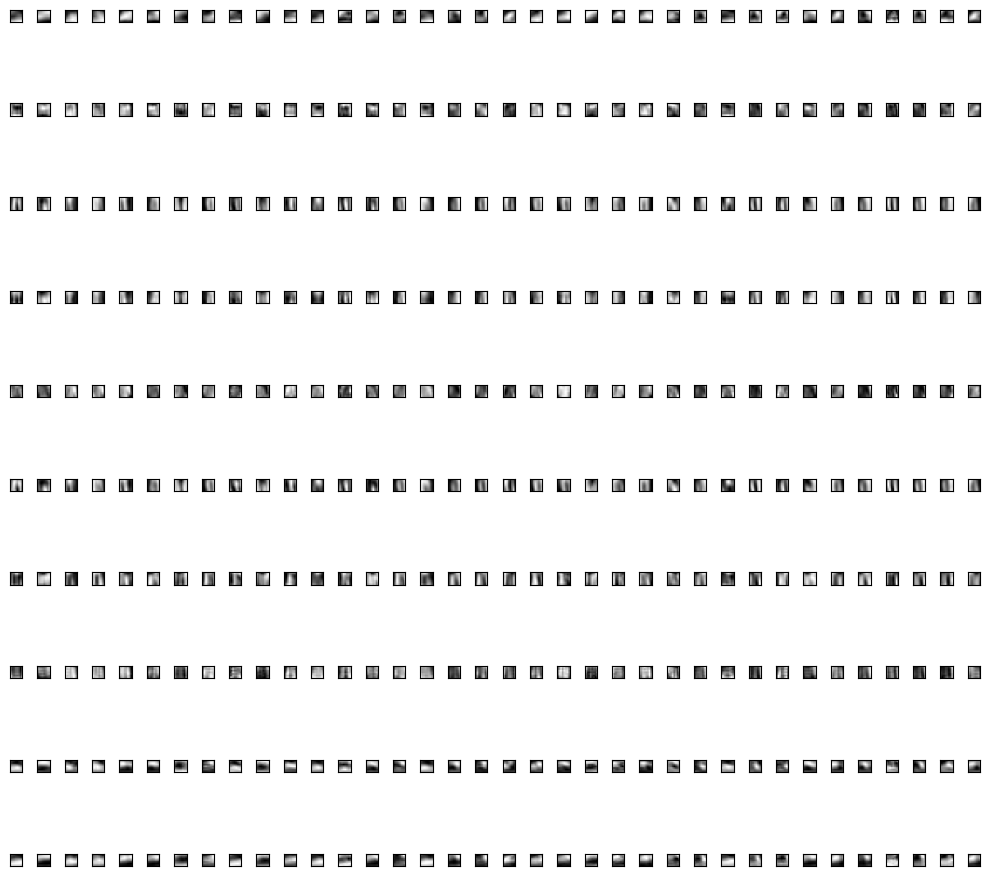

In [58]:
# Your Code Here
def hook_ShowOutput(module, input, output):
    print("Output shape:", output.shape)
    showConvMap(output.cpu())

# Get 10 images from the validation set
data, target = next(iter(val_loader))
data, target = data[:10].to(device), target[:10].to(device)

# Register hooks for the first and last convolutional layers
handle1 = model.conv1.register_forward_hook(hook_ShowOutput)
handle2 = model.conv2.register_forward_hook(hook_ShowOutput)

# Run the model on the data to trigger the hooks
with torch.no_grad():
    output = model(data)

# Remove the hooks
handle1.remove()
handle2.remove()

---

*Your Answer Here*

---